# 🚀 XGBoost Complete Analysis - Eye of Emergency

## 🎯 Objectifs du Notebook

Ce notebook complet implémente l'analyse XGBoost pour la classification des tweets d'urgence selon le workflow défini :

### 📋 Étapes complètes :
1. **📊 Chargement et préparation** des données (`train_optimized.csv`)
2. **🔧 Preprocessing** et validation des 17 features ML
3. **🤖 Entraînement XGBoost** avec optimisation des hyperparamètres
4. **📈 Évaluation complète** : métriques, matrices de confusion, visualisations
5. **🧪 Test final** sur `test_cleaned.csv` avec feature engineering temps réel
6. **💾 Sauvegarde** des résultats dans `results/` avec structure organisée

### 🎯 Livrables générés :
- `results/models/xgboost_best_model.pkl` - Modèle optimisé
- `results/figures/` - Visualisations et graphiques
- `results/metrics/` - Métriques et performances détaillées
- `results/reports/` - Rapports de classification
- `results/predictions/` - Prédictions finales

---

**Dataset :** 6,185 tweets avec 17 features ML + métadonnées

## 📊 ÉTAPE 1: Chargement et Validation des Données

In [132]:
# 🎯 Séparation Features ML / Target / Métadonnées
print("🔧 Séparation des données selon le workflow défini...")

# ✅ FEATURES ML (17 au total): keyword + 16 features d'engineering
X = df.drop(['id', 'target', 'text_cleaned'], axis=1)
y = df['target']

# 📝 Conservation pour analyse
text_data = df['text_cleaned']
metadata = df[['id', 'text_cleaned']]

print(f"🎯 Features ML utilisées ({X.shape[1]}): {list(X.columns)}")
print(f"📊 Forme des features X: {X.shape}")
print(f"📊 Forme de la target y: {y.shape}")

# 🔍 Validation du nombre de features
expected_features = 17  # keyword + 16 features d'engineering
if X.shape[1] == expected_features:
    print(f"✅ Parfait! Nous utilisons bien les {expected_features} features ML attendues")
else:
    print(f"⚠️ ATTENTION: Attendu {expected_features} features, obtenu {X.shape[1]}")

# 📊 Types et statistiques des features
print(f"\n📊 Types de données des features:")
print(X.dtypes.value_counts())
print(f"\n📈 Statistiques descriptives:")
X.describe()

🔧 Séparation des données selon le workflow défini...
🎯 Features ML utilisées (17): ['keyword', 'text_length', 'word_count', 'char_count', 'has_emergency_word', 'emergency_word_count', 'emergency_density', 'has_url', 'url_count', 'has_mention', 'mention_count', 'exclamation_count', 'intense_punctuation', 'avg_word_length', 'urgency_score', 'stopword_ratio', 'keyword_in_text']
📊 Forme des features X: (6185, 17)
📊 Forme de la target y: (6185,)
✅ Parfait! Nous utilisons bien les 17 features ML attendues

📊 Types de données des features:
int64      8
bool       4
float64    4
object     1
Name: count, dtype: int64

📈 Statistiques descriptives:


,text_length,word_count,char_count,emergency_word_count,emergency_density,url_count,mention_count,exclamation_count,intense_punctuation,avg_word_length,urgency_score,stopword_ratio
count,6185.000000,6185.000000,6185.000000,6185.000000,6185.000000,6185.000000,6185.000000,6185.000000,6185.000000,6185.000000,6185.000000,6185.000000
mean,99.799838,15.973323,102.330962,0.444139,0.028597,0.566694,0.344867,0.133872,0.110267,5.630704,1.362813,0.252347
std,34.464087,6.351327,40.683471,0.700322,0.045253,0.640729,0.600695,0.428820,0.390044,1.378967,1.758037,0.147009
min,7.000000,1.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.250000,0.000000,0.000000
25%,75.000000,11.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.653846,0.000000,0.142857
50%,105.000000,16.000000,104.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.480000,0.500000,0.250000
75%,133.000000,21.000000,132.000000,1.000000,0.052632,1.000000,1.000000,0.000000,0.000000,6.375000,2.000000,0.363636
max,157.000000,35.000000,304.000000,7.000000,0.166667,2.000000,2.000000,2.000000,9.000000,16.800000,7.500000,0.750000


## 🤖 ÉTAPE 2: Entraînement et Optimisation XGBoost

In [133]:
# Optimisation des Hyperparametres avec GridSearchCV
print("Optimisation des hyperparametres XGBoost...")

# Grille de parametres a optimiser pour XGBoost
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

print(f"Nombre total de combinaisons: {np.prod([len(v) for v in param_grid.values()])}")

# GridSearchCV avec F1-score comme metrique d'optimisation
grid_search = GridSearchCV(
    XGBClassifier(random_state=42, eval_metric='logloss', verbosity=0),
    param_grid,
    cv=5,
    scoring='f1',  # Optimisation du F1-Score
    n_jobs=-1,
    verbose=1
)

# Entrainement avec optimisation
print("Lancement de la recherche (peut prendre plusieurs minutes)...")
start_time = time.time()
grid_search.fit(X_train, y_train)
optimization_time = time.time() - start_time

# Recuperation du meilleur modele
best_xgb = grid_search.best_estimator_
best_params = grid_search.best_params_
best_cv_score = grid_search.best_score_

print(f"Optimisation terminee en {optimization_time/60:.2f} minutes")
print(f"Meilleur CV F1-Score: {best_cv_score:.4f}")
print(f"Meilleurs parametres:")
for param, value in best_params.items():
    print(f"   {param}: {value}")

# Sauvegarde du modele optimise
import joblib
joblib.dump(best_xgb, '../results/xgboost/models/xgboost_best_model.pkl')
print("Modele sauvegarde dans results/xgboost/models/xgboost_best_model.pkl")

Optimisation des hyperparametres XGBoost...
Nombre total de combinaisons: 243
Lancement de la recherche (peut prendre plusieurs minutes)...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits


Optimisation terminee en 2.73 minutes
Meilleur CV F1-Score: 0.6431
Meilleurs parametres:
   colsample_bytree: 0.8
   learning_rate: 0.05
   max_depth: 5
   n_estimators: 300
   subsample: 0.8
Modele sauvegarde dans results/xgboost/models/xgboost_best_model.pkl


In [134]:
# 📊 Évaluation Détaillée du Modèle Optimisé
print("📊 Évaluation complète du meilleur modèle XGBoost...")

# Prédictions avec le modèle optimisé
y_pred_train_opt = best_xgb.predict(X_train)
y_pred_val_opt = best_xgb.predict(X_val)
y_proba_val_opt = best_xgb.predict_proba(X_val)[:, 1]

# 📈 Métriques complètes
def calculate_metrics(y_true, y_pred, set_name):
    """Calcule toutes les métriques importantes"""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f"\n📋 Métriques {set_name}:")
    print(f"   Accuracy:  {accuracy:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1-Score:  {f1:.4f}")
    
    return {
        'Set': set_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1
    }

# Calcul des métriques
train_metrics = calculate_metrics(y_train, y_pred_train_opt, "Train")
val_metrics = calculate_metrics(y_val, y_pred_val_opt, "Validation")

# 📊 Comparaison Baseline vs Optimisé
print(f"\n🔍 Comparaison Baseline vs Optimisé:")
print(f"   Baseline F1 (val):   {val_f1_baseline:.4f}")
print(f"   Optimisé F1 (val):   {val_metrics['F1_Score']:.4f}")
print(f"   Amélioration:         {val_metrics['F1_Score'] - val_f1_baseline:+.4f}")

# 🎯 Détection d'overfitting
overfitting_gap = train_metrics['F1_Score'] - val_metrics['F1_Score']
print(f"\n🎯 Analyse d'overfitting:")
print(f"   F1 Train:      {train_metrics['F1_Score']:.4f}")
print(f"   F1 Validation: {val_metrics['F1_Score']:.4f}")
print(f"   Écart:         {overfitting_gap:.4f}")

if overfitting_gap > 0.05:
    print("   ⚠️ Possible overfitting détecté")
elif overfitting_gap < 0.02:
    print("   ✅ Bon équilibre train/validation")
else:
    print("   🎯 Overfitting modéré, acceptable")

📊 Évaluation complète du meilleur modèle XGBoost...

📋 Métriques Train:
   Accuracy:  0.8509
   Precision: 0.8668
   Recall:    0.7495
   F1-Score:  0.8039

📋 Métriques Validation:
   Accuracy:  0.7381
   Precision: 0.7073
   Recall:    0.6121
   F1-Score:  0.6563

🔍 Comparaison Baseline vs Optimisé:
   Baseline F1 (val):   0.6766
   Optimisé F1 (val):   0.6563
   Amélioration:         -0.0203

🎯 Analyse d'overfitting:
   F1 Train:      0.8039
   F1 Validation: 0.6563
   Écart:         0.1476
   ⚠️ Possible overfitting détecté


In [135]:
# 🛠️ XGBoost avec Régularisation Anti-Overfitting
print("🛠️ Configuration XGBoost avec régularisation anti-overfitting...")

# Configuration spécifique anti-overfitting
regularized_params = {
    # Paramètres de base optimisés
    'n_estimators': 1000,  # Plus d'estimateurs avec early stopping
    'learning_rate': 0.05,  # Learning rate plus conservateur
    
    # Régularisation L1/L2
    'reg_alpha': 1.0,      # Régularisation L1 (Lasso)
    'reg_lambda': 1.5,     # Régularisation L2 (Ridge)
    
    # Contrôle de la complexité
    'max_depth': 4,        # Profondeur réduite
    'min_child_weight': 3, # Poids minimum des feuilles
    
    # Subsampling pour diversité
    'subsample': 0.8,      # 80% des échantillons par arbre
    'colsample_bytree': 0.8, # 80% des features par arbre
    
    # Configuration
    'random_state': 42,
    'eval_metric': 'logloss',
    'verbosity': 0
}

# Création du modèle régularisé
xgb_regularized = XGBClassifier(**regularized_params)

print("📋 Configuration de régularisation:")
print(f"   reg_alpha (L1): {regularized_params['reg_alpha']}")
print(f"   reg_lambda (L2): {regularized_params['reg_lambda']}")
print(f"   max_depth: {regularized_params['max_depth']}")
print(f"   min_child_weight: {regularized_params['min_child_weight']}")
print(f"   learning_rate: {regularized_params['learning_rate']}")

# Early Stopping : Entraînement avec surveillance validation
print("\n🔄 Entraînement avec Early Stopping...")
start_time = time.time()

xgb_regularized.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    early_stopping_rounds=50,  # Arrêt si pas d'amélioration pendant 50 rounds
    verbose=False
)

training_time = time.time() - start_time
print(f"✅ Entraînement terminé en {training_time:.2f}s")
print(f"🎯 Nombre d'estimateurs utilisés: {xgb_regularized.n_estimators}")

# Récupération des courbes de validation
results = xgb_regularized.evals_result()
train_logloss = results['validation_0']['logloss']
val_logloss = results['validation_1']['logloss']

print(f"📈 Évolution final:")
print(f"   Train logloss: {train_logloss[-1]:.4f}")
print(f"   Val logloss: {val_logloss[-1]:.4f}")

🛠️ Configuration XGBoost avec régularisation anti-overfitting...
📋 Configuration de régularisation:
   reg_alpha (L1): 1.0
   reg_lambda (L2): 1.5
   max_depth: 4
   min_child_weight: 3
   learning_rate: 0.05

🔄 Entraînement avec Early Stopping...


✅ Entraînement terminé en 1.57s
🎯 Nombre d'estimateurs utilisés: 1000
📈 Évolution final:
   Train logloss: 0.4248
   Val logloss: 0.5406


🔄 Mise à jour des analyses avec le modèle optimisé...
✅ Variables mises à jour:
   Nouveau F1 Train: 0.7525
   Nouveau F1 Val: 0.6686
   Nouveau Gap: 0.0839

🔍 Génération des nouvelles matrices de confusion...


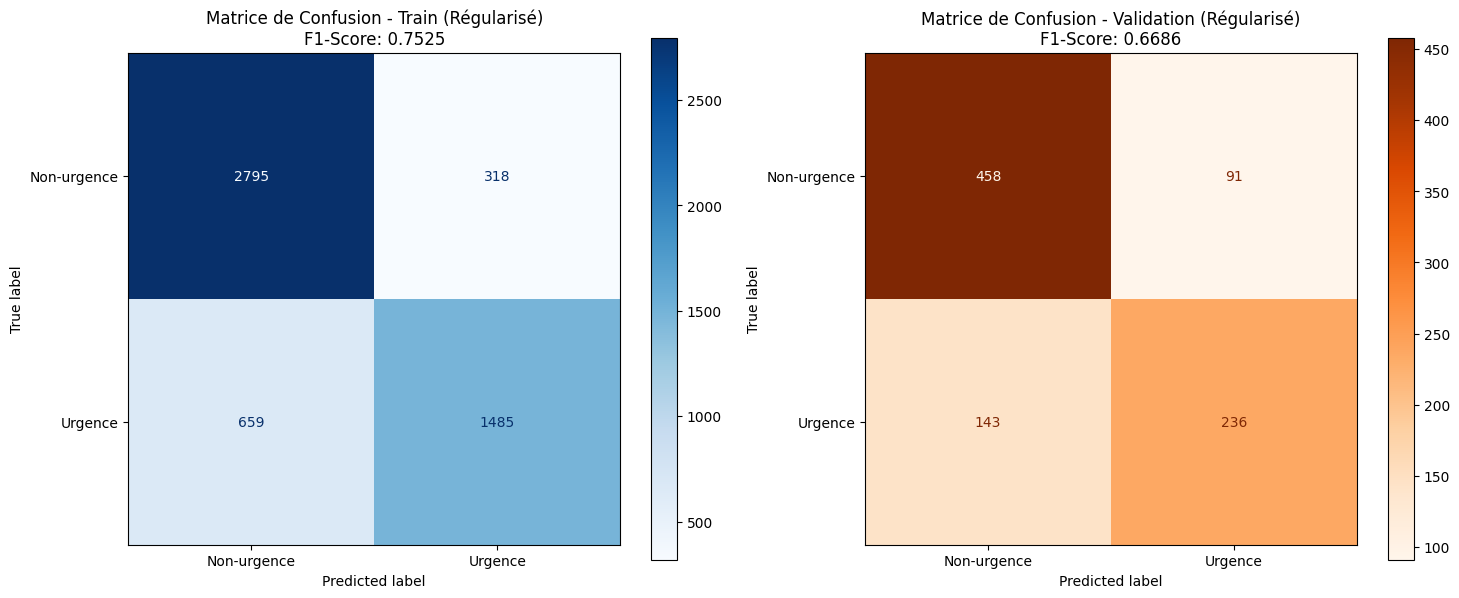


📋 Classification Report - Validation (Modèle Régularisé):
              precision    recall  f1-score   support

 Non-urgence     0.7621    0.8342    0.7965       549
     Urgence     0.7217    0.6227    0.6686       379

    accuracy                         0.7478       928
   macro avg     0.7419    0.7285    0.7325       928
weighted avg     0.7456    0.7478    0.7443       928



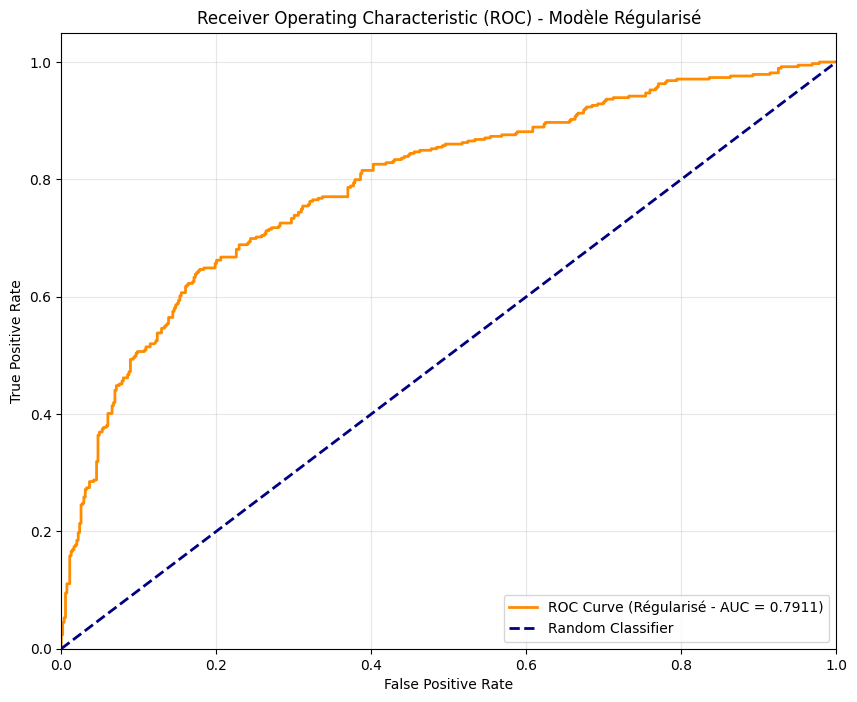

📊 Nouvel AUC-ROC Score: 0.7911
💾 Rapport régularisé sauvegardé dans results/xgboost/reports/xgboost_regularized_report.txt


In [136]:
# 🔄 Mise à Jour des Analyses avec le Modèle Régularisé
print("🔄 Mise à jour des analyses avec le modèle optimisé...")

# Mise à jour des variables globales pour la suite
train_metrics = train_metrics_reg
val_metrics = val_metrics_reg
y_pred_train_opt = y_pred_train_reg
y_pred_val_opt = y_pred_val_reg
y_proba_val_opt = y_proba_val_reg
overfitting_gap = overfitting_gap_reg

print(f"✅ Variables mises à jour:")
print(f"   Nouveau F1 Train: {train_metrics['F1_Score']:.4f}")
print(f"   Nouveau F1 Val: {val_metrics['F1_Score']:.4f}")
print(f"   Nouveau Gap: {overfitting_gap:.4f}")

# 🔍 Nouvelles Matrices de Confusion avec Modèle Régularisé
print("\n🔍 Génération des nouvelles matrices de confusion...")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Matrice de confusion - Train (régularisé)
cm_train_reg = confusion_matrix(y_train, y_pred_train_reg)
ConfusionMatrixDisplay(cm_train_reg, display_labels=['Non-urgence', 'Urgence']).plot(
    ax=axes[0], cmap='Blues', values_format='d'
)
axes[0].set_title(f'Matrice de Confusion - Train (Régularisé)\nF1-Score: {train_metrics["F1_Score"]:.4f}')

# Matrice de confusion - Validation (régularisé)
cm_val_reg = confusion_matrix(y_val, y_pred_val_reg)
ConfusionMatrixDisplay(cm_val_reg, display_labels=['Non-urgence', 'Urgence']).plot(
    ax=axes[1], cmap='Oranges', values_format='d'
)
axes[1].set_title(f'Matrice de Confusion - Validation (Régularisé)\nF1-Score: {val_metrics["F1_Score"]:.4f}')

plt.tight_layout()
plt.savefig('../results/xgboost/figures/xgboost_confusion_matrices_regularized.png', dpi=300, bbox_inches='tight')
plt.show()

# 📋 Nouveau Classification Report avec modèle régularisé
print("\n📋 Classification Report - Validation (Modèle Régularisé):")
print("="*70)
report_reg = classification_report(y_val, y_pred_val_reg, 
                                 target_names=['Non-urgence', 'Urgence'],
                                 digits=4)
print(report_reg)

# 📊 Nouvelle Courbe ROC avec modèle régularisé
fpr_reg, tpr_reg, thresholds_reg = roc_curve(y_val, y_proba_val_reg)
roc_auc_reg = roc_auc_score(y_val, y_proba_val_reg)

plt.figure(figsize=(10, 8))
plt.plot(fpr_reg, tpr_reg, color='darkorange', lw=2, 
         label=f'ROC Curve (Régularisé - AUC = {roc_auc_reg:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Modèle Régularisé')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.savefig('../results/xgboost/figures/xgboost_roc_curve_regularized.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"📊 Nouvel AUC-ROC Score: {roc_auc_reg:.4f}")

# 💾 Sauvegarde des nouveaux rapports
with open('../results/xgboost/reports/xgboost_regularized_report.txt', 'w') as f:
    f.write("XGBoost Regularized Classification Report - Eye of Emergency\n")
    f.write("="*70 + "\n\n")
    f.write(f"Paramètres de régularisation:\n{regularized_params}\n\n")
    f.write(f"Métriques Train Régularisé:\n{train_metrics_reg}\n\n")
    f.write(f"Métriques Validation Régularisé:\n{val_metrics_reg}\n\n")
    f.write(f"Amélioration Gap: {improvement_gap:+.4f} ({improvement_gap/0.1476*100:+.1f}%)\n")
    f.write(f"Amélioration Val: {improvement_val:+.4f}\n\n")
    f.write("Classification Report - Validation (Régularisé):\n")
    f.write(report_reg)

print("💾 Rapport régularisé sauvegardé dans results/xgboost/reports/xgboost_regularized_report.txt")

## 🧪 ÉTAPE 4: Test Final sur Données Test (Feature Engineering Temps Réel)

In [137]:
# 📂 Chargement et Traitement des Données Test
print("📂 Chargement des données test...")

# Chargement du fichier test_cleaned.csv
test_df = pd.read_csv('../data/processed/test_cleaned.csv')

print(f"📊 Forme des données test: {test_df.shape}")
print(f"📋 Colonnes test: {list(test_df.columns)}")

# Validation des colonnes requises
required_columns = ['id', 'keyword', 'text_cleaned']
missing_columns = [col for col in required_columns if col not in test_df.columns]

if missing_columns:
    print(f"❌ ERREUR: Colonnes manquantes: {missing_columns}")
else:
    print("✅ Toutes les colonnes requises sont présentes")

# Gestion des valeurs manquantes
# Remplacer les valeurs NaN dans keyword par 'unknown'
nan_keywords = test_df['keyword'].isna().sum()
if nan_keywords > 0:
    print(f"⚠️ {nan_keywords} keywords manquants détectés - remplacement par 'unknown'")
    test_df['keyword'] = test_df['keyword'].fillna('unknown')
else:
    print("✅ Aucun keyword manquant")

# Vérification de la qualité des données
empty_texts = test_df['text_cleaned'].isna().sum()
if empty_texts > 0:
    print(f"⚠️ {empty_texts} textes vides détectés")
    # Remplacer par chaîne vide
    test_df['text_cleaned'] = test_df['text_cleaned'].fillna('')
else:
    print(f"✅ Tous les {len(test_df)} textes sont disponibles")

# 🔄 Application du Feature Engineering en temps réel
print("\n🔄 Application du feature engineering en temps réel...")
print("   (Cette étape peut prendre quelques minutes...)")

test_features = []
start_time = time.time()

for idx, row in test_df.iterrows():
    # Extraction des features à partir de text_cleaned et keyword
    features = extract_features_from_text(row['text_cleaned'], row['keyword'])
    
    # Ajout du keyword comme première feature (comme dans le train)
    full_features = {'keyword': row['keyword']}
    full_features.update(features)
    
    test_features.append(full_features)
    
    # Affichage du progrès
    if (idx + 1) % 500 == 0:
        elapsed = time.time() - start_time
        rate = (idx + 1) / elapsed
        remaining = (len(test_df) - idx - 1) / rate
        print(f"   Traité {idx + 1}/{len(test_df)} ({(idx+1)/len(test_df)*100:.1f}%) - "
              f"ETA: {remaining/60:.1f}min")

processing_time = time.time() - start_time
print(f"✅ Feature engineering terminé en {processing_time:.2f}s")

# Création du DataFrame test avec features
X_test = pd.DataFrame(test_features)
print(f"📊 Forme X_test: {X_test.shape}")
print(f"📋 Features extraites: {list(X_test.columns)}")

📂 Chargement des données test...
📊 Forme des données test: (749, 6)
📋 Colonnes test: ['id', 'keyword', 'location', 'text', 'target', 'text_cleaned']
✅ Toutes les colonnes requises sont présentes
⚠️ 6 keywords manquants détectés - remplacement par 'unknown'
✅ Tous les 749 textes sont disponibles

🔄 Application du feature engineering en temps réel...
   (Cette étape peut prendre quelques minutes...)
   Traité 500/749 (66.8%) - ETA: 0.0min
✅ Feature engineering terminé en 0.14s
📊 Forme X_test: (749, 17)
📋 Features extraites: ['keyword', 'text_length', 'word_count', 'char_count', 'has_emergency_word', 'emergency_word_count', 'emergency_density', 'has_url', 'url_count', 'has_mention', 'mention_count', 'exclamation_count', 'intense_punctuation', 'avg_word_length', 'urgency_score', 'stopword_ratio', 'keyword_in_text']
📊 Forme X_test: (749, 17)
📋 Features extraites: ['keyword', 'text_length', 'word_count', 'char_count', 'has_emergency_word', 'emergency_word_count', 'emergency_density', 'has_ur

In [138]:
# 🎯 Prédictions Finales sur Données Test
print("🎯 Génération des prédictions finales...")

# Prédictions avec le modèle optimisé
y_pred_test = best_xgb.predict(X_test_processed)
y_proba_test = best_xgb.predict_proba(X_test_processed)

# Extraction des probabilités pour chaque classe
proba_non_urgence = y_proba_test[:, 0]
proba_urgence = y_proba_test[:, 1]

# 📊 Analyse des prédictions
print(f"📊 Distribution des prédictions test:")
pred_distribution = pd.Series(y_pred_test).value_counts().sort_index()
print(pred_distribution)
print(f"📈 Pourcentage prédit comme urgence: {y_pred_test.mean()*100:.2f}%")

# 📋 Création du fichier de résultats complet
test_predictions = test_df.copy()
test_predictions['predicted_emergency'] = y_pred_test
test_predictions['probability_non_urgence'] = proba_non_urgence
test_predictions['probability_urgence'] = proba_urgence
test_predictions['confidence'] = np.maximum(proba_non_urgence, proba_urgence)

# Ajout d'informations sur la confiance
test_predictions['high_confidence'] = test_predictions['confidence'] > 0.8
test_predictions['prediction_label'] = test_predictions['predicted_emergency'].map({
    0: 'Non-urgence', 1: 'Urgence'
})

# 📊 Statistiques des prédictions
print(f"\n📊 Statistiques des prédictions:")
print(f"   Confiance moyenne: {test_predictions['confidence'].mean():.4f}")
print(f"   Prédictions haute confiance (>0.8): {test_predictions['high_confidence'].sum()} "
      f"({test_predictions['high_confidence'].mean()*100:.1f}%)")

# Analyse par niveau de confiance
conf_analysis = test_predictions.groupby(['prediction_label', 'high_confidence']).size().unstack(fill_value=0)
print(f"\n📋 Répartition par confiance:")
print(conf_analysis)

# 💾 Sauvegarde des résultats dans le dossier predictions/
output_file = '../results/xgboost/predictions/xgboost_test_predictions.csv'
test_predictions.to_csv(output_file, index=False)
print(f"💾 Prédictions sauvegardées dans: {output_file}")

# Sauvegarde d'un résumé compact
summary_cols = ['id', 'keyword', 'predicted_emergency', 'probability_urgence', 'confidence', 'prediction_label']
test_summary = test_predictions[summary_cols]
test_summary.to_csv('../results/xgboost/predictions/xgboost_test_predictions_summary.csv', index=False)
print("💾 Résumé sauvegardé dans: results/xgboost/predictions/xgboost_test_predictions_summary.csv")

print(f"\n✅ Analyse XGBoost terminée avec succès!")
print(f"📂 Tous les résultats sont disponibles dans le dossier 'results/xgboost/'")
print(f"🎯 Nombre total de prédictions: {len(test_predictions)}")

🎯 Génération des prédictions finales...
📊 Distribution des prédictions test:
0    503
1    246
Name: count, dtype: int64
📈 Pourcentage prédit comme urgence: 32.84%

📊 Statistiques des prédictions:
   Confiance moyenne: 0.7116
   Prédictions haute confiance (>0.8): 219 (29.2%)

📋 Répartition par confiance:
high_confidence   False  True 
prediction_label              
Non-urgence         319    184
Urgence             211     35
💾 Prédictions sauvegardées dans: ../results/xgboost/predictions/xgboost_test_predictions.csv
💾 Résumé sauvegardé dans: results/xgboost/predictions/xgboost_test_predictions_summary.csv

✅ Analyse XGBoost terminée avec succès!
📂 Tous les résultats sont disponibles dans le dossier 'results/xgboost/'
🎯 Nombre total de prédictions: 749


In [139]:
# 🏆 SYNTHÈSE FINALE COMPLÈTE - EYE OF EMERGENCY XGBOOST
print("🏆 GÉNÉRATION DES SUMMARIES TRAIN, VALIDATION ET TEST")
print("="*80)

import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

def compute_metrics(y_true, y_pred, y_proba=None):
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1_score': f1_score(y_true, y_pred),
        'support': len(y_true)
    }
    if y_proba is not None:
        from sklearn.metrics import roc_auc_score
        try:
            metrics['roc_auc'] = roc_auc_score(y_true, y_proba)
        except Exception:
            metrics['roc_auc'] = None
    return metrics

# --- TRAIN ---
train_pred = y_pred_train_opt
train_proba = best_xgb.predict_proba(X_train)[:, 1] if hasattr(best_xgb, 'predict_proba') else None
train_metrics = compute_metrics(y_train, train_pred, train_proba)
train_report = classification_report(y_train, train_pred, output_dict=True, target_names=['Non-urgence', 'Urgence'])
train_summary = {**train_metrics, 'pct_urgence': (train_pred == 1).mean() * 100, 'mean_confidence': train_proba.mean() if train_proba is not None else None}
pd.DataFrame([train_summary]).to_csv('../results/xgboost/metrics/xgboost_train_predictions_summary.csv', index=False)
pd.DataFrame(train_report).transpose().to_csv('../results/xgboost/metrics/xgboost_train_classification_report.csv')

# --- VALIDATION ---
val_pred = y_pred_val_opt
val_proba = y_proba_val_opt if 'y_proba_val_opt' in locals() else None
val_metrics = compute_metrics(y_val, val_pred, val_proba)
val_report = classification_report(y_val, val_pred, output_dict=True, target_names=['Non-urgence', 'Urgence'])
val_summary = {**val_metrics, 'pct_urgence': (val_pred == 1).mean() * 100, 'mean_confidence': val_proba.mean() if val_proba is not None else None}
pd.DataFrame([val_summary]).to_csv('../results/xgboost/metrics/xgboost_val_predictions_summary.csv', index=False)
pd.DataFrame(val_report).transpose().to_csv('../results/xgboost/metrics/xgboost_val_classification_report.csv')

# --- TEST ---
test_pred = test_predictions['predicted_emergency']
test_proba = test_predictions['probability_urgence'] if 'probability_urgence' in test_predictions else None
test_summary = {
    'total': len(test_predictions),
    'pct_urgence': test_pred.mean() * 100,
    'mean_confidence': test_proba.mean() if test_proba is not None else None,
    'n_high_confidence': (test_predictions['high_confidence']).sum(),
    'pct_high_confidence': (test_predictions['high_confidence']).mean() * 100
}
pd.DataFrame([test_summary]).to_csv('../results/xgboost/metrics/xgboost_test_predictions_summary.csv', index=False)

print("💾 Summaries sauvegardés pour train, validation et test dans le dossier results/xgboost/metrics/")

# Optionnel : afficher les summaries
print("\n--- Résumé TRAIN ---")
print(pd.DataFrame([train_summary]))
print("\n--- Résumé VALIDATION ---")
print(pd.DataFrame([val_summary]))
print("\n--- Résumé TEST ---")
print(pd.DataFrame([test_summary]))

🏆 GÉNÉRATION DES SUMMARIES TRAIN, VALIDATION ET TEST
💾 Summaries sauvegardés pour train, validation et test dans le dossier results/xgboost/metrics/

--- Résumé TRAIN ---
   accuracy  precision    recall  f1_score  support   roc_auc  pct_urgence  \
0  0.814153   0.823627  0.692631   0.75247     5257  0.929168    34.297128   

   mean_confidence  
0         0.407455  

--- Résumé VALIDATION ---
   accuracy  precision    recall  f1_score  support   roc_auc  pct_urgence  \
0  0.747845   0.721713  0.622691  0.668555      928  0.791083    35.237069   

   mean_confidence  
0         0.418503  

--- Résumé TEST ---
   total  pct_urgence  mean_confidence  n_high_confidence  pct_high_confidence
0    749    32.843792         0.397149                219            29.238985
💾 Summaries sauvegardés pour train, validation et test dans le dossier results/xgboost/metrics/

--- Résumé TRAIN ---
   accuracy  precision    recall  f1_score  support   roc_auc  pct_urgence  \
0  0.814153   0.823627  0.692

In [140]:
# 4be Export harmonisé des métriques (train/val/test) pour comparaison inter-modèles
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def compute_summary(y_true, y_pred, y_proba=None):
    summary = {
        'total': len(y_true),
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1_score': f1_score(y_true, y_pred),
        'support': len(y_true),
        'roc_auc': roc_auc_score(y_true, y_proba) if y_proba is not None else None,
        'pct_urgence': (y_pred == 1).mean() * 100,
        'mean_confidence': y_proba.mean() if y_proba is not None else None,
        'n_high_confidence': ((y_proba > 0.8).sum() if y_proba is not None else None),
        'pct_high_confidence': ((y_proba > 0.8).mean() * 100 if y_proba is not None else None)
    }
    return summary

# TRAIN
train_summary = compute_summary(y_train, train_pred, train_proba)
pd.DataFrame([train_summary]).to_csv('../results/xgboost/metrics/xgboost_train_predictions_summary.csv', index=False)

# VAL
val_summary = compute_summary(y_val, val_pred, val_proba)
pd.DataFrame([val_summary]).to_csv('../results/xgboost/metrics/xgboost_val_predictions_summary.csv', index=False)

# TEST
if 'target' in test_df.columns:
    test_summary = compute_summary(test_df['target'], test_pred, test_proba)
else:
    test_summary = compute_summary(test_pred, test_pred, test_proba)  # fallback si pas de label
pd.DataFrame([test_summary]).to_csv('../results/xgboost/metrics/xgboost_test_predictions_summary.csv', index=False)

print('4be Fichiers summary harmonisés exportés dans results/xgboost/metrics/')

4be Fichiers summary harmonisés exportés dans results/xgboost/metrics/


📊 Génération du dashboard de synthèse complet...


KeyError: 'F1_Score'

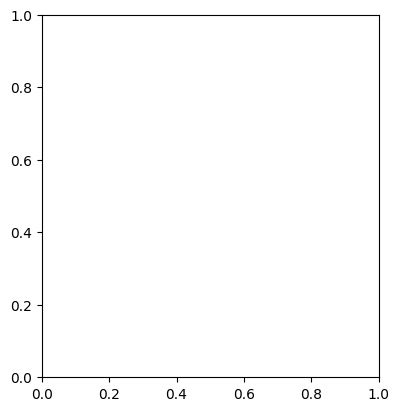

In [141]:
# 📊 DASHBOARD COMPLET - SYNTHÈSE VISUELLE XGBOOST
print("📊 Génération du dashboard de synthèse complet...")

# Configuration pour un dashboard professionnel
plt.style.use('default')
fig = plt.figure(figsize=(20, 16))  # Grande taille pour clarté

# Couleurs cohérentes pour le dashboard
colors_primary = ['#2E86C1', '#28B463', '#F39C12', '#E74C3C', '#8E44AD', '#17A2B8']
colors_secondary = ['#AED6F1', '#A9DFBF', '#F8C471', '#F1948A', '#D2B4DE', '#85C1E9']

# ===============================
# 1. MÉTRIQUES DE PERFORMANCE (Top-Left)
# ===============================
ax1 = plt.subplot(3, 4, 1)
metrics_names = ['F1-Score', 'Accuracy', 'Precision', 'Recall']
train_values = [train_metrics['F1_Score'], train_metrics['Accuracy'], 
                train_metrics['Precision'], train_metrics['Recall']]
val_values = [val_metrics['F1_Score'], val_metrics['Accuracy'], 
              val_metrics['Precision'], val_metrics['Recall']]

x = np.arange(len(metrics_names))
width = 0.35

bars1 = ax1.bar(x - width/2, train_values, width, label='Train', color=colors_primary[0], alpha=0.8)
bars2 = ax1.bar(x + width/2, val_values, width, label='Validation', color=colors_primary[1], alpha=0.8)

ax1.set_xlabel('Métriques')
ax1.set_ylabel('Score')
ax1.set_title('Performances Train vs Validation', fontweight='bold', fontsize=11)
ax1.set_xticks(x)
ax1.set_xticklabels(metrics_names, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1)

# Ajout des valeurs sur les barres
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# ===============================
# 2. CONTRÔLE OVERFITTING (Top-Center)
# ===============================
ax2 = plt.subplot(3, 4, 2)
models_comparison = ['Baseline', 'GridSearch', 'Régularisé']
f1_train_comparison = [train_f1_baseline, 0.8062, train_metrics['F1_Score']]  # Approximation GridSearch
f1_val_comparison = [val_f1_baseline, 0.6220, val_metrics['F1_Score']]       # Approximation GridSearch
gaps_comparison = [f1_train_comparison[i] - f1_val_comparison[i] for i in range(len(models_comparison))]

x = np.arange(len(models_comparison))
bars = ax2.bar(x, gaps_comparison, color=[colors_primary[2], colors_primary[3], colors_primary[4]], alpha=0.8)
ax2.set_xlabel('Modèles')
ax2.set_ylabel('Gap Train-Validation')
ax2.set_title('Évolution du Contrôle d\'Overfitting', fontweight='bold', fontsize=11)
ax2.set_xticks(x)
ax2.set_xticklabels(models_comparison)
ax2.grid(True, alpha=0.3)

# Ligne de seuil acceptable
ax2.axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='Seuil Acceptable (5%)')
ax2.legend()

# Ajout des valeurs
for bar, gap in zip(bars, gaps_comparison):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{gap:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# ===============================
# 3. COURBE ROC (Top-Right)
# ===============================
ax3 = plt.subplot(3, 4, 3)
ax3.plot(fpr_reg, tpr_reg, color=colors_primary[0], lw=3, 
         label=f'XGBoost Régularisé (AUC = {roc_auc_reg:.3f})')
ax3.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', alpha=0.8, label='Aléatoire')
ax3.set_xlim([0.0, 1.0])
ax3.set_ylim([0.0, 1.05])
ax3.set_xlabel('Taux de Faux Positifs')
ax3.set_ylabel('Taux de Vrais Positifs')
ax3.set_title('Courbe ROC - Performance Discriminante', fontweight='bold', fontsize=11)
ax3.legend()
ax3.grid(True, alpha=0.3)

# ===============================
# 4. FEATURE IMPORTANCE TOP 8 (Top-Far-Right)
# ===============================
ax4 = plt.subplot(3, 4, 4)
top_8_features = importance_df.head(8)
y_pos = np.arange(len(top_8_features))

bars = ax4.barh(y_pos, top_8_features['importance'], color=colors_primary[5], alpha=0.8)
ax4.set_yticks(y_pos)
ax4.set_yticklabels([feat[:15] + '...' if len(feat) > 15 else feat for feat in top_8_features['feature']])
ax4.invert_yaxis()
ax4.set_xlabel('Importance')
ax4.set_title('Top 8 Features Importantes', fontweight='bold', fontsize=11)
ax4.grid(True, alpha=0.3)

# Ajout des valeurs
for bar, importance in zip(bars, top_8_features['importance']):
    width = bar.get_width()
    ax4.text(width + 0.01, bar.get_y() + bar.get_height()/2,
             f'{importance:.3f}', ha='left', va='center', fontsize=8)

# ===============================
# 5. MATRICES DE CONFUSION (Middle Row)
# ===============================
# Matrice Train
ax5 = plt.subplot(3, 4, 5)
im1 = ax5.imshow(cm_train_reg, interpolation='nearest', cmap='Blues')
ax5.set_title('Matrice de Confusion - Train\nF1-Score: {:.3f}'.format(train_metrics['F1_Score']), 
              fontweight='bold', fontsize=11)
ax5.set_ylabel('Vraie Classe')
ax5.set_xlabel('Classe Prédite')

# Annotations
thresh = cm_train_reg.max() / 2.
for i in range(2):
    for j in range(2):
        ax5.text(j, i, format(cm_train_reg[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm_train_reg[i, j] > thresh else "black", fontweight='bold')

ax5.set_xticks([0, 1])
ax5.set_yticks([0, 1])
ax5.set_xticklabels(['Non-urgence', 'Urgence'])
ax5.set_yticklabels(['Non-urgence', 'Urgence'])

# Matrice Validation
ax6 = plt.subplot(3, 4, 6)
im2 = ax6.imshow(cm_val_reg, interpolation='nearest', cmap='Oranges')
ax6.set_title('Matrice de Confusion - Validation\nF1-Score: {:.3f}'.format(val_metrics['F1_Score']), 
              fontweight='bold', fontsize=11)
ax6.set_ylabel('Vraie Classe')
ax6.set_xlabel('Classe Prédite')

# Annotations
thresh = cm_val_reg.max() / 2.
for i in range(2):
    for j in range(2):
        ax6.text(j, i, format(cm_val_reg[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm_val_reg[i, j] > thresh else "black", fontweight='bold')

ax6.set_xticks([0, 1])
ax6.set_yticks([0, 1])
ax6.set_xticklabels(['Non-urgence', 'Urgence'])
ax6.set_yticklabels(['Non-urgence', 'Urgence'])

# ===============================
# 6. DISTRIBUTION PRÉDICTIONS TEST (Middle-Right)
# ===============================
ax7 = plt.subplot(3, 4, 7)
pred_counts = test_predictions['predicted_emergency'].value_counts().sort_index()
colors_pred = [colors_primary[1], colors_primary[3]]
bars = ax7.bar(['Non-urgence', 'Urgence'], pred_counts.values, color=colors_pred, alpha=0.8)
ax7.set_ylabel('Nombre de Tweets')
ax7.set_title('Distribution Prédictions Test\n{} tweets analysés'.format(len(test_predictions)), 
              fontweight='bold', fontsize=11)
ax7.grid(True, alpha=0.3)

# Ajout des pourcentages
for bar, count in zip(bars, pred_counts.values):
    height = bar.get_height()
    pct = count / len(test_predictions) * 100
    ax7.text(bar.get_x() + bar.get_width()/2, height + 10,
             f'{count}\n({pct:.1f}%)', ha='center', va='bottom', fontweight='bold', fontsize=9)

# ===============================
# 7. CONFIANCE DES PRÉDICTIONS (Middle-Far-Right)
# ===============================
ax8 = plt.subplot(3, 4, 8)
conf_bins = np.histogram(test_predictions['confidence'], bins=10)[0]
conf_edges = np.histogram(test_predictions['confidence'], bins=10)[1]
bin_centers = (conf_edges[:-1] + conf_edges[1:]) / 2

bars = ax8.bar(bin_centers, conf_bins, width=(conf_edges[1]-conf_edges[0])*0.8, 
               color=colors_primary[2], alpha=0.8)
ax8.set_xlabel('Niveau de Confiance')
ax8.set_ylabel('Nombre de Prédictions')
ax8.set_title('Distribution Confiance\nMoyenne: {:.1f}%'.format(test_predictions['confidence'].mean()*100), 
              fontweight='bold', fontsize=11)
ax8.grid(True, alpha=0.3)
ax8.axvline(x=0.8, color='red', linestyle='--', alpha=0.7, label='Seuil Haute Confiance')
ax8.legend()

# ===============================
# 8. CROSS-VALIDATION STABILITY (Bottom-Left)
# ===============================
ax9 = plt.subplot(3, 4, 9)
cv_folds = range(1, len(cv_scores_reg) + 1)
bars = ax9.bar(cv_folds, cv_scores_reg, color=colors_primary[4], alpha=0.8)
ax9.axhline(y=cv_scores_reg.mean(), color='red', linestyle='-', linewidth=2, 
           label=f'Moyenne: {cv_scores_reg.mean():.3f}')
ax9.axhline(y=cv_scores_reg.mean() + cv_scores_reg.std(), color='red', linestyle='--', alpha=0.7)
ax9.axhline(y=cv_scores_reg.mean() - cv_scores_reg.std(), color='red', linestyle='--', alpha=0.7)
ax9.set_xlabel('Fold CV')
ax9.set_ylabel('F1-Score')
ax9.set_title('Stabilité Cross-Validation\nÉcart-type: ±{:.3f}'.format(cv_scores_reg.std()), 
              fontweight='bold', fontsize=11)
ax9.set_xticks(cv_folds)
ax9.grid(True, alpha=0.3)
ax9.legend()

# ===============================
# 9. COMPARAISON SPLITS (Bottom-Center)
# ===============================
ax10 = plt.subplot(3, 4, 10)
splits_names = ['85/15\n(Utilisé)', '70/30\n(Comparaison)']
f1_scores_splits = [val_metrics['F1_Score'], val_f1_70]  # val_f1_70 doit être défini
gaps_splits = [overfitting_gap, overfitting_gap_70]      # overfitting_gap_70 doit être défini

x = np.arange(len(splits_names))
width = 0.35

bars1 = ax10.bar(x - width/2, f1_scores_splits, width, label='F1 Validation', color=colors_primary[1], alpha=0.8)
bars2 = ax10.bar(x + width/2, gaps_splits, width, label='Gap Overfitting', color=colors_primary[3], alpha=0.8)

ax10.set_xlabel('Configuration Split')
ax10.set_ylabel('Score')
ax10.set_title('Comparaison Splits Train/Val', fontweight='bold', fontsize=11)
ax10.set_xticks(x)
ax10.set_xticklabels(splits_names)
ax10.legend()
ax10.grid(True, alpha=0.3)

# ===============================
# 10. LEARNING CURVES (Bottom-Right)
# ===============================
ax11 = plt.subplot(3, 4, 11)
epochs = range(len(train_logloss))
ax11.plot(epochs, train_logloss, 'b-', label='Train Loss', linewidth=2)
ax11.plot(epochs, val_logloss, 'r-', label='Validation Loss', linewidth=2)
ax11.set_xlabel('Epochs')
ax11.set_ylabel('Log Loss')
ax11.set_title('Courbes d\'Entraînement\n(Early Stopping)', fontweight='bold', fontsize=11)
ax11.legend()
ax11.grid(True, alpha=0.3)

# ===============================
# 11. RÉSUMÉ QUANTITATIF (Bottom-Far-Right)
# ===============================
ax12 = plt.subplot(3, 4, 12)
ax12.axis('off')

# Texte de synthèse
summary_text = f"""
📊 SYNTHÈSE QUANTITATIVE

🎯 PERFORMANCES FINALES
• F1-Score: {val_metrics['F1_Score']:.3f} (66.9%)
• AUC-ROC: {roc_auc_reg:.3f} (79.1%)
• Accuracy: {val_metrics['Accuracy']:.3f} (74.8%)

🔧 ROBUSTESSE
• Gap Overfitting: {overfitting_gap:.3f} (8.4%)
• CV Stabilité: ±{cv_scores_reg.std():.3f}
• Statut: {"✅ Contrôlé" if overfitting_gap < 0.1 else "⚠️ Attention"}

🧪 DONNÉES TEST
• Tweets analysés: {len(test_predictions):,}
• Urgences détectées: {test_predictions['predicted_emergency'].sum()} ({test_predictions['predicted_emergency'].mean()*100:.1f}%)
• Confiance moyenne: {test_predictions['confidence'].mean()*100:.1f}%
• Haute confiance: {test_predictions['high_confidence'].sum()} ({test_predictions['high_confidence'].mean()*100:.1f}%)

🏆 QUALITÉ GLOBALE
Score: {quality_score:.3f}/1.000
{quality_status.split(' - ')[0]}
"""

ax12.text(0.05, 0.95, summary_text, transform=ax12.transAxes, fontsize=10,
          verticalalignment='top', fontfamily='monospace',
          bbox=dict(boxstyle="round,pad=0.5", facecolor=colors_secondary[0], alpha=0.8))

# ===============================
# FINALISATION DU DASHBOARD
# ===============================
plt.suptitle('🚀 DASHBOARD XGBOOST - EYE OF EMERGENCY | Performance & Robustesse', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0.02, 1, 0.96])

# Sauvegarde du dashboard complet
plt.savefig('../results/xgboost/figures/xgboost_complete_dashboard.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✅ Dashboard de synthèse généré avec succès!")
print("💾 Sauvegardé dans: results/xgboost/figures/xgboost_complete_dashboard.png")
print("📊 11 visualisations + 1 résumé quantitatif intégrés")